# Modelo Informer

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import Informer
from neuralforecast.losses.pytorch import MAE
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Establecer el estilo de las gráficas
plt.style.use('seaborn-v0_8')

2025-04-07 20:19:15,431	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-07 20:19:15,671	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Carga y Preprocesado del Dataset

In [2]:
tickers = ["AAPL", "AMZN", "TSLA", "GOOGL", "MSFT"]
dfs = []
i = 0
for ticker in tickers:
    df = pd.read_csv(f'../Data/Global_Data_{ticker}.csv', parse_dates=['Date'])
    df['unique_id'] = i  # Asigna un identificador numérico a cada ticket
    i += 1
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Definir las características (variables financieras y de sentimiento)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 
            'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal', 
            'avg_sentiment', 'weighted_sentiment', 'sentiment_sma_7', 
            'sentiment_sma_14', 'tweet_count']

# Filtrar el DataFrame y ordenarlo
df_filt = df[['Date', 'unique_id'] + features]
df_filt = df_filt.sort_values(by=['unique_id', 'Date'])

# Reindexar para que cada 'unique_id' tenga un índice diario completo
dfs_with_full_dates = []
for unique_id in df_filt['unique_id'].unique():
    df_ticker = df_filt[df_filt['unique_id'] == unique_id]
    full_idx_ticker = pd.date_range(start=df_ticker['Date'].min(), end=df_ticker['Date'].max(), freq='D')
    df_ticker_reindexed = df_ticker.set_index('Date').reindex(full_idx_ticker).reset_index()
    df_ticker_reindexed.rename(columns={'index': 'Date'}, inplace=True)
    df_ticker_reindexed['unique_id'] = unique_id
    dfs_with_full_dates.append(df_ticker_reindexed)
df_filt_full = pd.concat(dfs_with_full_dates, ignore_index=True)

# Imputar valores faltantes por interpolación lineal
df_filt_full[features] = df_filt_full[features].interpolate(method='linear')

### Creación de Nuevas Variables

In [3]:
# Variables exógenas futuras
lag = 14
for feat in ['Open', 'High', 'Low', 'Volume', 'Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']:
    df_filt_full[f"{feat}_lag{lag}"] = df_filt_full.groupby('unique_id')[feat].shift(lag)
for feat in ['weighted_sentiment', 'tweet_count', 'sentiment_sma_7', 'sentiment_sma_14']:
    df_filt_full[f"{feat}_lag{lag}"] = df_filt_full.groupby('unique_id')[feat].shift(lag)

# Variables exógenas históricas
df_filt_full['Close_SMA_10_hist'] = df_filt_full.groupby('unique_id')['Close'].transform(lambda x: x.rolling(10).mean().shift(14))
df_filt_full['Close_SMA_30_hist'] = df_filt_full.groupby('unique_id')['Close'].transform(lambda x: x.rolling(30).mean().shift(14))

df_filt_full['Close_momentum_hist'] = df_filt_full['Close'].pct_change(periods=10).shift(14)
df_filt_full['Close_volatility_20_hist'] = df_filt_full.groupby('unique_id')['Close'].transform(lambda x: x.rolling(20).std().shift(14))

### Definición del Dataset Final y de las Variables Exógenas

In [4]:
# Rellenar los valores faltantes con 0
df_filt_full = df_filt_full.fillna(0)

# Renombrar columnas para compatibilidad con Nixtla
df_final = df_filt_full.rename(columns={'Date': 'ds', 'Close': 'y'})

# Varibales exógenas futuras
futr_exog_list = [
    'Open_lag14', 'High_lag14', 'Low_lag14', 'Volume_lag14', 'Close_lag14',
    'SMA_50_lag14', 'SMA_200_lag14', 'RSI_lag14', 'MACD_lag14',
    'weighted_sentiment_lag14', 'sentiment_sma_7_lag14', 'sentiment_sma_14_lag14', 'tweet_count_lag14',
]

# Variables exógenas históricas
hist_exog_list = [
    'Close_SMA_10_hist', 'Close_SMA_30_hist', 'Close_momentum_hist', 'Close_volatility_20_hist'
]

df_final

,ds,unique_id,Open,High,Low,y,Volume,SMA_50,SMA_200,RSI,...,RSI_lag14,MACD_lag14,weighted_sentiment_lag14,tweet_count_lag14,sentiment_sma_7_lag14,sentiment_sma_14_lag14,Close_SMA_10_hist,Close_SMA_30_hist,Close_momentum_hist,Close_volatility_20_hist
0,2016-10-19,0,-1.923882,-1.940571,-1.987976,-1.923895,-0.843739,-2.227854,-2.383641,0.439562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-10-20,0,-1.925562,-1.951164,-1.916395,-1.934864,-0.541287,-2.222643,-2.380764,0.292853,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-10-21,0,-1.921433,-1.948655,-1.911656,-1.933176,-0.552137,-2.219828,-2.379146,0.306937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2016-10-22,0,-1.917303,-1.946146,-1.906917,-1.931489,-0.562988,-2.217013,-2.377527,0.321021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2016-10-23,0,-1.913173,-1.943637,-1.902178,-1.929801,-0.573839,-2.214198,-2.375909,0.335104,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,2019-12-27,4,2.078001,2.059150,2.101008,2.097364,-0.755330,1.872373,1.860070,1.736185,...,0.889952,0.918937,-0.945404,-0.138762,-0.109147,-0.406261,1.779864,1.758800,0.128969,0.045961
5841,2019-12-28,4,2.060497,2.052411,2.081831,2.091483,-0.814606,1.877174,1.863253,1.648411,...,1.070523,0.983453,-0.680183,-0.282788,-0.434407,-0.310079,1.793531,1.767345,0.078534,0.049675
5842,2019-12-29,4,2.042992,2.045672,2.062653,2.085602,-0.873882,1.881974,1.866436,1.560638,...,1.251094,1.047970,-0.414962,-0.426814,-0.759666,-0.213897,1.810240,1.774347,0.096209,0.054654
5843,2019-12-30,4,2.025487,2.038933,2.043476,2.079721,-0.933157,1.886774,1.869620,1.472865,...,1.431666,1.112487,-0.149741,-0.570840,-1.084926,-0.117715,1.826043,1.781762,0.089132,0.062528


### División el Dataset en Entrenamiento y Prueba

In [5]:
# Dividir en conjunto de entrenamiento y prueba
train = df_final[df_final['ds'] <= '2019-09-30']
test = df_final[(df_final['ds'] > '2019-09-30')].reset_index(drop=True)

print(train.shape[0])
print(test.shape[0])

# Unión para evaluación tipo rolling
full_df = pd.concat([train, test], ignore_index=True)

5385
460


## Entrenamiento del Modelo Informer

In [6]:
# Inicializar el modelo Informer
models = [
    Informer(
        h=14, 
        input_size=30,  
        hidden_size=128,
        conv_hidden_size=64,
        n_head=8,
        futr_exog_list=futr_exog_list,
        loss=MAE(),
        scaler_type='robust',
        learning_rate=1e-3,
        encoder_layers=3,
        decoder_layers=2,
        max_steps=600,
        batch_size=128,
        dropout=0.1
    )
]

# Crear el objeto NeuralForecast
nf = NeuralForecast(
    models=models,
    freq='D'  # Frecuencia diaria
)

# Entrenar el modelo Informer
nf.fit(df=train)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 2.0 K  | train
4 | dec_embedding | DataEmbedding | 2.0 K  | train
5 | encoder       | TransEncoder  | 348 K  | train
6 | decoder       | TransDecoder  | 299 K  | train
--------------------------------------------------------
652 K     Trainable params
0         Non-trainable params
652 K     Total params
2.608     Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=600` reached.


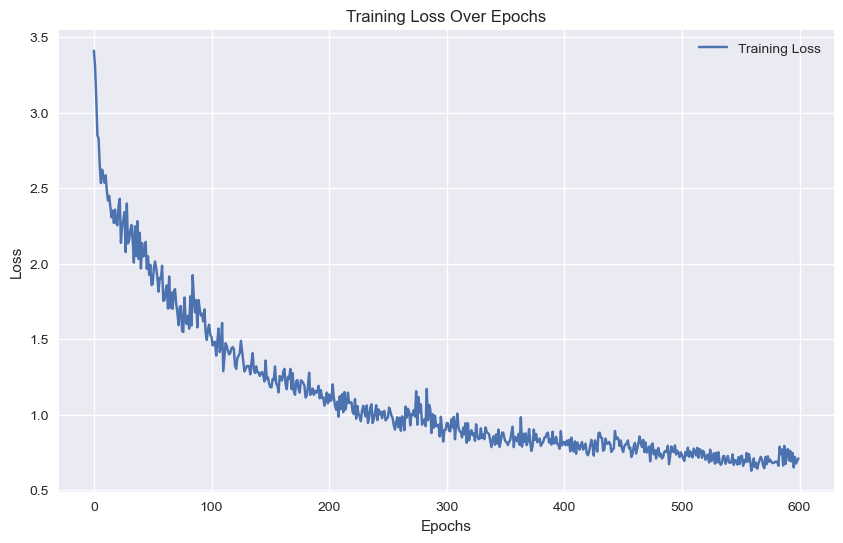

In [7]:
# Obtener el historial de pérdidas del modelo desde los resultados de entrenamiento
losses = nf.models[0].train_trajectories

# Extraer los valores de la pérdida y las épocas
epochs = [x[0] for x in losses]  # Épocas
train_loss = [x[1] for x in losses]  # Pérdidas

# Graficar las pérdidas de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss")

# Añadir etiquetas y título
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Mostrar la gráfica
plt.show()

## Evaluación del Modelo

In [8]:
# Calcular número de ventanas que caben en el test
test_horizon = test['ds'].nunique()
n_windows = (test_horizon - 14) // 14 + 1
print(f"Se usarán {n_windows} ventanas de validación.")

# Cross-validation con n_windows
cv_result = nf.cross_validation(
    df=full_df,
    n_windows=n_windows,
    step_size=14,
    refit=False,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Se usarán 6 ventanas de validación.



  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 2.0 K  | train
4 | dec_embedding | DataEmbedding | 2.0 K  | train
5 | encoder       | TransEncoder  | 348 K  | train
6 | decoder       | TransDecoder  | 299 K  | train
--------------------------------------------------------
652 K     Trainable params
0         Non-trainable params
652 K     Total params
2.608     Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=600` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

#### Métricas de Evaluación

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Calcular métricas por ticker
metrics = []

for uid in df_final['unique_id'].unique():
    y_true = cv_result[cv_result['unique_id'] == uid]['y'].values
    y_pred = cv_result[cv_result['unique_id'] == uid]['Informer'].values
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape_val = mape(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    
    metrics.append({
        'Ticker': tickers[uid],
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape_val,
        'SMAPE (%)': smape_val
    })

metrics_df = pd.DataFrame(metrics)
metrics_df.round(3)

,Ticker,MAE,MSE,RMSE,MAPE (%),SMAPE (%)
0,AAPL,0.165,0.053,0.230,8.190,8.844
1,AMZN,0.068,0.008,0.092,9.106,8.705
2,TSLA,0.627,0.596,0.772,128.630,64.745
3,GOOGL,0.231,0.075,0.273,13.972,14.718
4,MSFT,0.133,0.029,0.170,8.259,8.704


#### Resultados para una Empresa

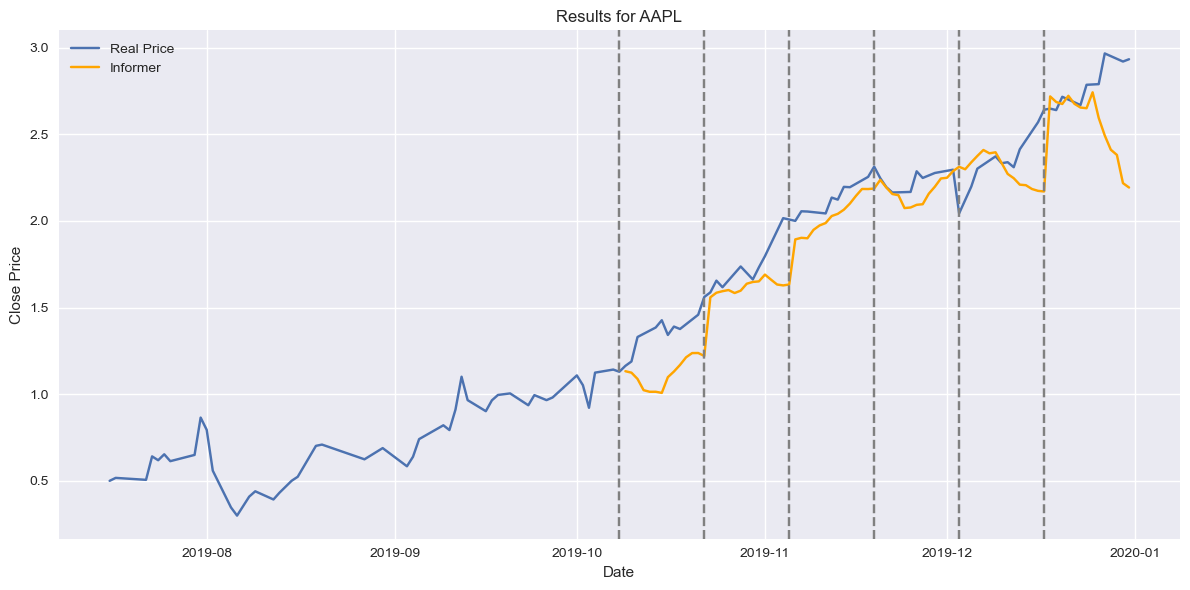

In [ ]:
# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ticker = 0  # ID de AAPL
y_real = df_final[df_final['unique_id'] == ticker][1000:]  # Filtrar los datos a partir de un índice específico
cv_res = cv_result[cv_result['unique_id'] == ticker]  # Resultados de la validación cruzada para la empresa

# Obtener los puntos de corte únicos de la validación cruzada
cutoffs = cv_res['cutoff'].unique()

# Graficar los datos reales y predicciones
ax.plot(y_real['ds'], y_real['y'], label="Real Price ")
ax.plot(cv_res['ds'], cv_res['Informer'], label='Informer', color='orange')

# Añadir las líneas de corte
for cutoff in cutoffs:
    ax.axvline(x=cutoff, color='grey', ls='--')

# Configurar el gráfico
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.set_title('Results for AAPL')
ax.legend()

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

#### Resultados de las Empresas

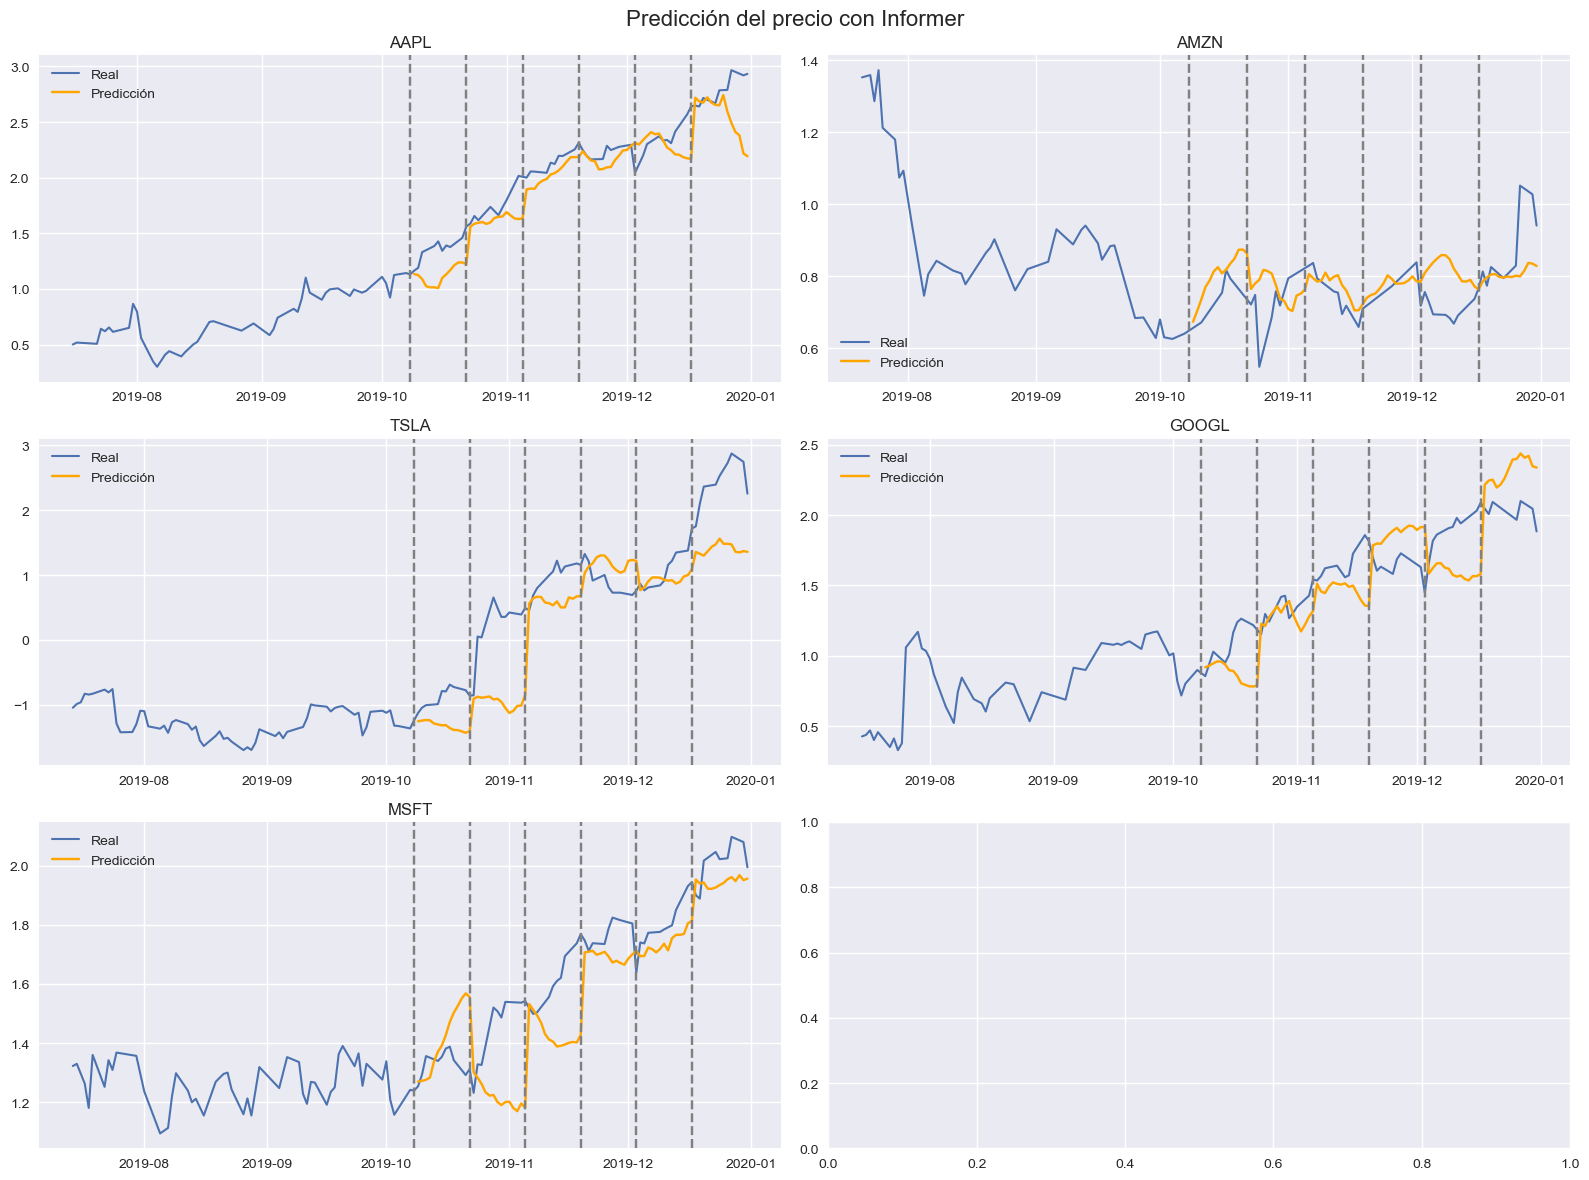

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, uid in enumerate(df_final['unique_id'].unique()):
    actual = df_final[df_final['unique_id'] == uid][1000:]
    pred = cv_result[cv_result['unique_id'] == uid]

    ax = axes[i]
    ax.plot(actual['ds'], actual['y'], label='Real', linewidth=1.5)
    ax.plot(pred['ds'], pred['Informer'], label='Predicción', color='orange')
    # Añadir las líneas de corte
    for cutoff in cutoffs:
        ax.axvline(x=cutoff, color='grey', ls='--')
    ax.set_title(f'{tickers[uid]}')
    ax.grid(True)
    ax.legend()

fig.suptitle('Predicción del precio con Informer', fontsize=16)
plt.tight_layout()
plt.show()
